In [7]:
import ast
from pathlib import Path

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

pd.set_option("display.max_columns", 140)
pd.set_option("display.width", 160)
pd.set_option("display.max_colwidth", 200)

In [ ]:
CSV_PATH = Path("../cleaned_data/movies_metadata_cleaned.csv")

df = pd.read_csv(CSV_PATH, low_memory=False)
df.shape, df.head(3)

((45466, 24),
    adult  \
 0  False   
 1  False   
 2  False   
 
                                                                                                                                          belongs_to_collection  \
 0        {'id': 10194, 'name': 'Toy Story Collection', 'poster_path': '/7G9915LfUQ2lVfwMEEhDsn3kT4B.jpg', 'backdrop_path': '/9FBwqcd9IRruEDUrTdcaafOMKUq.jpg'}   
 1                                                                                                                                                          NaN   
 2  {'id': 119050, 'name': 'Grumpy Old Men Collection', 'poster_path': '/nLvUdqgPgm3F85NMCii9gVFUcet.jpg', 'backdrop_path': '/hypTnLot2z8wpFS7qwsQHW1uV8u.jpg'}   
 
      budget                                                                                             genres                              homepage     id  \
 0  30000000   [{'id': 16, 'name': 'Animation'}, {'id': 35, 'name': 'Comedy'}, {'id': 10751, 'name': 'Family'}]  http:

In [10]:
print("Shape:", df.shape)

print("\nDtypes:")
display(df.dtypes.to_frame("dtype"))

print("\nMissing values (raw columns):")
na = df.isna().sum().rename("missing")
display(
    pd.concat([na, (na/len(df)*100).rename("missing_%").round(2)], axis=1)
      .sort_values("missing_%", ascending=False)
)

print("\nZero counts in numeric columns:")
num_cols = df.select_dtypes(include=[np.number]).columns.tolist()
if num_cols:
    z = pd.Series({c: int((df[c] == 0).sum()) for c in num_cols}, name="zero_count")
    display(z.sort_values(ascending=False).to_frame())
else:
    print("No numeric columns detected.")


# =========================
# JSON parsing + integrity
# =========================

import ast
import pandas as pd

def safe_parse_any(x):
    """Parse a JSON-like string into Python obj (dict/list). Return None when blank/invalid."""
    if pd.isna(x) or not isinstance(x, str) or not x.strip():
        return None
    try:
        return ast.literal_eval(x)
    except Exception:
        return None

def parse_to_dict(x):
    """Return a dict or {}. Accept string (to parse) or already-dict."""
    if isinstance(x, dict):
        return x
    val = safe_parse_any(x)
    return val if isinstance(val, dict) else {}

def parse_to_list_of_dicts(x):
    """Return list[dict]. Accept string (to parse) or already-list. Non-dict items are dropped."""
    if isinstance(x, list):
        return [d for d in x if isinstance(d, dict)]
    val = safe_parse_any(x)
    if isinstance(val, list):
        return [d for d in val if isinstance(d, dict)]
    return []

def count_missing_fields_in_dict_series(s: pd.Series, required_fields):
    """
    For a Series of dicts, count how many dicts are empty (== {}) and,
    among non-empty dicts, how many are missing/blank per field.
    """
    total = len(s)
    empty = (s.apply(lambda d: not bool(d))).sum()
    non_empty_mask = s.apply(lambda d: bool(d))
    non_empty = int(non_empty_mask.sum())

    field_stats = []
    if non_empty > 0:
        sub = s[non_empty_mask]
        for f in required_fields:
            missing_f = sub.apply(lambda d: (f not in d) or (d[f] is None) or (str(d[f]).strip() == "")).sum()
            field_stats.append({"field": f, "missing_count": int(missing_f), "missing_%_of_non_empty": round(missing_f / non_empty * 100, 2)})
    return total, int(empty), non_empty, pd.DataFrame(field_stats)

def count_missing_fields_in_list_of_dicts(s: pd.Series, required_fields):
    """
    For a Series of list[dict], compute:
    - rows_empty: rows where list is empty
    - item-level field missing counts across all dict items (flattened)
    """
    total_rows = len(s)
    rows_empty = (s.apply(lambda lst: len(lst) == 0)).sum()

    # Flatten all dicts
    all_items = [d for lst in s for d in lst]
    items_total = len(all_items)

    stats = []
    if items_total > 0:
        for f in required_fields:
            missing = sum((f not in d) or (d[f] is None) or (str(d[f]).strip() == "") for d in all_items)
            stats.append({
                "field": f,
                "items_missing": int(missing),
                "items_missing_%": round(missing / items_total * 100, 2),
            })
    return int(rows_empty), items_total, pd.DataFrame(stats)


# ---------- belongs_to_collection (DICT) ----------
if "belongs_to_collection" in df.columns:
    df["belongs_to_collection_obj"] = df["belongs_to_collection"].apply(parse_to_dict)

    btc_total, btc_empty, btc_non_empty, btc_field_df = count_missing_fields_in_dict_series(
        df["belongs_to_collection_obj"],
        required_fields=["id", "name", "poster_path", "backdrop_path"]
    )
    print("\n[belongs_to_collection] dict integrity:")
    print(f"  total rows: {btc_total}")
    print(f"  empty dicts ({{}}): {btc_empty}")   # <-- fixed braces here
    print(f"  non-empty dicts: {btc_non_empty}")
    if not btc_field_df.empty:
        display(btc_field_df)

# ---------- genres (LIST[DICT]) ----------
if "genres" in df.columns:
    df["genres_list"] = df["genres"].apply(parse_to_list_of_dicts)
    g_rows_empty, g_items_total, g_field_df = count_missing_fields_in_list_of_dicts(
        df["genres_list"], required_fields=["id", "name"]
    )
    print("\n[genres] list-of-dicts integrity:")
    print(f"  rows with empty list: {g_rows_empty}")
    print(f"  total dict items: {g_items_total}")
    if not g_field_df.empty:
        display(g_field_df)

# ---------- production_companies (LIST[DICT]) ----------
if "production_companies" in df.columns:
    df["production_companies_list"] = df["production_companies"].apply(parse_to_list_of_dicts)
    pc_rows_empty, pc_items_total, pc_field_df = count_missing_fields_in_list_of_dicts(
        df["production_companies_list"], required_fields=["id", "name"]
    )
    print("\n[production_companies] list-of-dicts integrity:")
    print(f"  rows with empty list: {pc_rows_empty}")
    print(f"  total dict items: {pc_items_total}")
    if not pc_field_df.empty:
        display(pc_field_df)

# ---------- production_countries (LIST[DICT]) ----------
if "production_countries" in df.columns:
    df["production_countries_list"] = df["production_countries"].apply(parse_to_list_of_dicts)
    prc_rows_empty, prc_items_total, prc_field_df = count_missing_fields_in_list_of_dicts(
        df["production_countries_list"], required_fields=["iso_3166_1", "name"]
    )
    print("\n[production_countries] list-of-dicts integrity:")
    print(f"  rows with empty list: {prc_rows_empty}")
    print(f"  total dict items: {prc_items_total}")
    if not prc_field_df.empty:
        display(prc_field_df)

# ---------- spoken_languages (LIST[DICT]) ----------
if "spoken_languages" in df.columns:
    df["spoken_languages_list"] = df["spoken_languages"].apply(parse_to_list_of_dicts)
    sl_rows_empty, sl_items_total, sl_field_df = count_missing_fields_in_list_of_dicts(
        df["spoken_languages_list"], required_fields=["iso_639_1", "name"]
    )
    print("\n[spoken_languages] list-of-dicts integrity:")
    print(f"  rows with empty list: {sl_rows_empty}")
    print(f"  total dict items: {sl_items_total}")
    if not sl_field_df.empty:
        display(sl_field_df)

# Optional per-row counts
for col in ["genres_list", "production_companies_list", "production_countries_list", "spoken_languages_list"]:
    if col in df.columns:
        df[f"{col}_count"] = df[col].apply(len)


Shape: (45466, 24)

Dtypes:


,dtype
adult,object
belongs_to_collection,object
budget,object
genres,object
homepage,object
id,object
imdb_id,object
original_language,object
original_title,object
overview,object



Missing values (raw columns):


,missing,missing_%
belongs_to_collection,40972,90.12
homepage,37684,82.88
tagline,25054,55.10
overview,954,2.10
poster_path,386,0.85
runtime,263,0.58
status,87,0.19
release_date,87,0.19
imdb_id,17,0.04
original_language,11,0.02



Zero counts in numeric columns:


,zero_count
revenue,38052
vote_average,2998
vote_count,2899
runtime,1558



[belongs_to_collection] dict integrity:
  total rows: 45466
  empty dicts ({}): 40975
  non-empty dicts: 4491


,field,missing_count,missing_%_of_non_empty
0,id,0,0.00
1,name,0,0.00
2,poster_path,543,12.09
3,backdrop_path,1228,27.34



[genres] list-of-dicts integrity:
  rows with empty list: 2442
  total dict items: 91106


,field,items_missing,items_missing_%
0,id,0,0.0
1,name,0,0.0



[production_companies] list-of-dicts integrity:
  rows with empty list: 11881
  total dict items: 70545


,field,items_missing,items_missing_%
0,id,0,0.0
1,name,0,0.0



[production_countries] list-of-dicts integrity:
  rows with empty list: 6288
  total dict items: 49423


,field,items_missing,items_missing_%
0,iso_3166_1,0,0.0
1,name,0,0.0



[spoken_languages] list-of-dicts integrity:
  rows with empty list: 3835
  total dict items: 53300


,field,items_missing,items_missing_%
0,iso_639_1,0,0.00
1,name,498,0.93


In [11]:
import json

def make_hashable(x):
    """Convert unhashables (list/dict/set/ndarray) to stable strings/tuples for nunique/duplicated."""
    if isinstance(x, (list, dict, set)):
        try:
            return json.dumps(x, sort_keys=True)
        except Exception:
            return str(x)
    if isinstance(x, np.ndarray):
        return tuple(x.tolist())
    return x

print("Unique values per column (robust to list/dict):")
unique_counts = {}
for col in df.columns:
    s = df[col]
    if s.dtype == "object":
        unique_counts[col] = s.map(make_hashable).nunique(dropna=False)
    else:
        unique_counts[col] = s.nunique(dropna=False)
display(pd.Series(unique_counts, name="n_unique").sort_values(ascending=False).to_frame())

# Fully duplicated rows (convert object cols first on a copy)
df_for_dups = df.copy()
for col in df_for_dups.select_dtypes(include=["object"]).columns:
    df_for_dups[col] = df_for_dups[col].map(make_hashable)

dup_rows = int(df_for_dups.duplicated().sum())
print(f"\nDuplicate rows (entire row identical): {dup_rows}")

# Column-specific duplicates
if "id" in df.columns:
    print("Duplicate IDs:", int(df["id"].duplicated().sum()))
if "imdb_id" in df.columns:
    print("Duplicate imdb_id:", int(df["imdb_id"].duplicated().sum()))

# Duplicates in JSON-like string columns
for col in ["belongs_to_collection", "genres", "production_companies", "production_countries", "spoken_languages"]:
    if col in df.columns:
        dup_col = int(df[col].map(make_hashable).duplicated().sum())
        print(f"Duplicate '{col}' entries:", dup_col)


Unique values per column (robust to list/dict):


,n_unique
id,45436
imdb_id,45418
poster_path,45025
overview,44308
popularity,43759
original_title,43373
title,42278
production_companies,22709
production_companies_list,22707
tagline,20284



Duplicate rows (entire row identical): 17
Duplicate IDs: 30
Duplicate imdb_id: 48
Duplicate 'belongs_to_collection' entries: 43767
Duplicate 'genres' entries: 41397
Duplicate 'production_companies' entries: 22757
Duplicate 'production_countries' entries: 43072
Duplicate 'spoken_languages' entries: 43534



=== Movie Status Overview ===


,count,percent
status,,
Released,45014,99.01
Rumored,230,0.51
Post Production,98,0.22
Unknown,87,0.19
In Production,20,0.04
Planned,15,0.03
Canceled,2,0.00


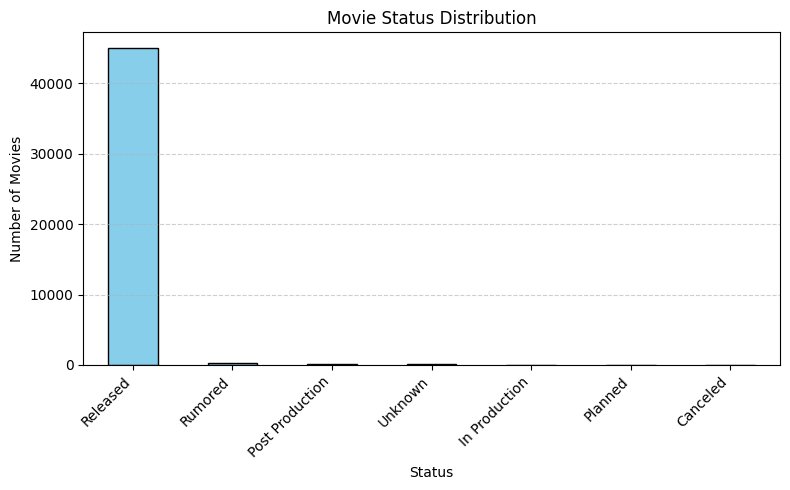

In [ ]:
if "status" in df.columns:
    print("\n=== Movie Status Overview ===")
    status_counts = df["status"].fillna("Unknown").value_counts(dropna=False)
    status_percent = (status_counts / len(df) * 100).round(2)
    
    status_df = pd.DataFrame({
        "count": status_counts,
        "percent": status_percent
    }).sort_values("count", ascending=False)
    
    display(status_df)

    plt.figure(figsize=(8, 5))
    status_counts.plot(kind="bar", color="skyblue", edgecolor="black")
    plt.title("Movie Status Distribution")
    plt.xlabel("Status")
    plt.ylabel("Number of Movies")
    plt.xticks(rotation=45, ha="right")
    plt.grid(axis="y", linestyle="--", alpha=0.6)
    plt.tight_layout()
    plt.show()
else:
    print("\nNo 'status' column found in dataset.")


=== Movie Runtime Analysis ===
Total movies: 45466
Movies with runtime = 0: 1558 (3.43%)
Movies with missing runtime: 263 (0.58%)
Movies with valid runtime: 43645 (95.99%)


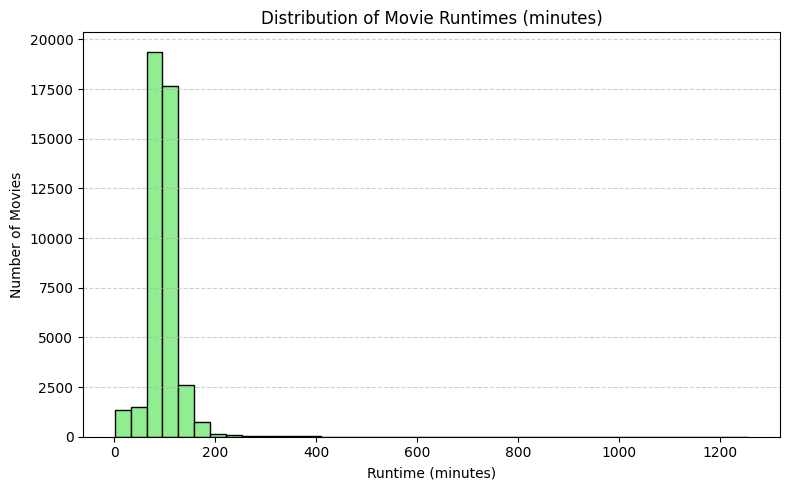


Runtime summary statistics (valid only):


,runtime
count,43645.000000
mean,97.488303
std,34.644505
min,1.000000
25%,86.000000
50%,95.000000
75%,107.000000
max,1256.000000


In [13]:
if "runtime" in df.columns:
    print("\n=== Movie Runtime Analysis ===")
    
    # Count how many movies have runtime = 0 or are missing
    total = len(df)
    zero_runtime = (df["runtime"] == 0).sum()
    missing_runtime = df["runtime"].isna().sum()
    valid_runtime = total - zero_runtime - missing_runtime

    print(f"Total movies: {total}")
    print(f"Movies with runtime = 0: {zero_runtime} ({round(zero_runtime / total * 100, 2)}%)")
    print(f"Movies with missing runtime: {missing_runtime} ({round(missing_runtime / total * 100, 2)}%)")
    print(f"Movies with valid runtime: {valid_runtime} ({round(valid_runtime / total * 100, 2)}%)")

    # Plot the runtime distribution for valid entries
    valid_runtimes = df.loc[df["runtime"] > 0, "runtime"].dropna()

    if not valid_runtimes.empty:
        plt.figure(figsize=(8, 5))
        plt.hist(valid_runtimes, bins=40, color="lightgreen", edgecolor="black")
        plt.title("Distribution of Movie Runtimes (minutes)")
        plt.xlabel("Runtime (minutes)")
        plt.ylabel("Number of Movies")
        plt.grid(axis="y", linestyle="--", alpha=0.6)
        plt.tight_layout()
        plt.show()

        # Show summary stats
        print("\nRuntime summary statistics (valid only):")
        display(valid_runtimes.describe(percentiles=[0.25, 0.5, 0.75]).to_frame("runtime"))
    else:
        print("\nNo valid runtimes found (all 0 or missing).")
else:
    print("\nNo 'runtime' column found in dataset.")
